# Modelo Churn

## Generacion de la clase_ternaria

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

In [ ]:
require( "data.table" )

# leo el dataset
dataset <- fread("/content/datasets/competencia_01_crudo.csv" )

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
    "pos" = .I,
    numero_de_cliente,
    periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 ) ]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
    shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente ]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
    ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
    clase_ternaria := "BAJA+1" ]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
    & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
    clase_ternaria := "BAJA+2" ]


# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

# fwrite( dataset,
#     file =  "/content/datasets/competencia_01.csv.gz",
#     sep = ","
# )

Loading required package: data.table



In [ ]:
# --- PASO 1: Feature Engineering de Eventos (Aguinaldo) ---
# Se realiza primero, usando los valores nominales originales.

cat("Paso 1: Creando flag de Aguinaldo y normalizando payroll...\n")
setorder(dataset, numero_de_cliente, foto_mes)

# 1.1. Crear el flag 'recibe_aguinaldo' usando el ingreso total
dataset[, ingreso_total_payroll := mpayroll + mpayroll2]
dataset[, lag_ingreso_total := shift(ingreso_total_payroll, n = 1, type = "lag"), by = numero_de_cliente]
dataset[, recibe_aguinaldo := 0L]
dataset[foto_mes == 202106 &
        lag_ingreso_total > 0 &
        (ingreso_total_payroll / lag_ingreso_total) >= 1.3 &
        (ingreso_total_payroll / lag_ingreso_total) <= 1.8,
        recibe_aguinaldo := 1L]

# 1.2. Crear la columna 'mpayroll_normalizado'
dataset[, mpayroll_normalizado := ingreso_total_payroll]
dataset[foto_mes == 202106 & recibe_aguinaldo == 1,
        mpayroll_normalizado := ingreso_total_payroll / 1.5]

# 1.3. Limpieza inmediata de columnas originales de payroll
dataset[, c("ingreso_total_payroll", "lag_ingreso_total", "mpayroll", "mpayroll2") := NULL]


cat("Paso 1: Flag de Aguinaldo y normalización completados. Originales de payroll eliminadas.\n")


Paso 1: Creando flag de Aguinaldo y normalizando payroll...
Paso 1: Flag de Aguinaldo y normalización completados. Originales de payroll eliminadas.


In [ ]:
# --- PASO 2: Feature Engineering de Agregación y Ratios ---


# 2.1. Definición de grupos de columnas (exhaustiva)
cols_activos_liquidos <- c("mcuenta_corriente_adicional", "mcuenta_corriente", "mcaja_ahorro", "mcaja_ahorro_adicional", "mcaja_ahorro_dolares", "mplazo_fijo_dolares", "mplazo_fijo_pesos", "minversion1_pesos", "minversion1_dolares", "minversion2")
cols_deuda_tarjetas <- c("Master_msaldototal", "Visa_msaldototal")
cols_ingresos <- c("mtransferencias_recibidas", "mcheques_depositados")
cols_gastos <- c("mcomisiones", "mactivos_margen", "mtarjeta_visa_consumo", "mtarjeta_master_consumo", "mcuenta_debitos_automaticos", "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos", "mpagodeservicios", "mpagomiscuentas", "mtransferencias_emitidas", "mextraccion_autoservicio", "mcheques_emitidos", "mforex_buy", "Master_madelantopesos", "Master_madelantodolares", "Visa_madelantopesos", "Visa_madelantodolares")

# 2.2. Creación de variables agregadas
dataset[, total_activos_liquidos := rowSums(.SD, na.rm = TRUE), .SDcols = cols_activos_liquidos]
dataset[, total_deuda_tarjetas := rowSums(.SD, na.rm = TRUE), .SDcols = cols_deuda_tarjetas]
dataset[, total_ingresos := rowSums(.SD, na.rm = TRUE), .SDcols = cols_ingresos]
dataset[, total_gastos := rowSums(.SD, na.rm = TRUE), .SDcols = cols_gastos]

# 2.3. Creación de Ratios de Negocio (¡Nuevas y potentes!)
# Se usa 'fifelse' para manejar divisiones por cero de forma segura
dataset[, ratio_deuda_ingreso := fifelse(total_ingresos > 0, total_deuda_tarjetas / total_ingresos, 0)]
dataset[, ratio_gasto_ingreso := fifelse(total_ingresos > 0, total_gastos / total_ingresos, 0)]
dataset[, ratio_uso_visa := fifelse(Visa_mlimitecompra > 0, mtarjeta_visa_consumo / Visa_mlimitecompra, 0)]
dataset[, ratio_uso_master := fifelse(Master_mlimitecompra > 0, mtarjeta_master_consumo / Master_mlimitecompra, 0)]
dataset[, ratio_fuga_capital := fifelse(mtransferencias_recibidas > 0, mtransferencias_emitidas / mtransferencias_recibidas, 0)]




cat("Paso 2: Creadas variables agregadas y ratios de negocio...\n")


Paso 2: Creadas variables agregadas y ratios de negocio...


In [ ]:
# --- PASO 3: Feature Engineering "Efecto Anticipación" ---
cat("Paso 3: Creando flag de 'Efecto Anticipación'...\n")

dataset[, lag_total_gastos := shift(total_gastos, n = 1, type = "lag"), by = numero_de_cliente]
dataset[, anticipa_gasto := 0L]
dataset[foto_mes == 202105 & lag_total_gastos > 0 & (total_gastos / lag_total_gastos) >= 1.20, anticipa_gasto := 1L]
dataset[, lag1_anticipa_gasto := shift(anticipa_gasto, n = 1, type = "lag"), by = numero_de_cliente]
dataset[, c("lag_total_gastos", "anticipa_gasto") := NULL]
setnames(dataset, "lag1_anticipa_gasto", "anticipa_gasto_en_mayo")
dataset[is.na(anticipa_gasto_en_mayo), anticipa_gasto_en_mayo := 0] # Limpieza de NAs


Paso 3: Creando flag de 'Efecto Anticipación'...


In [ ]:
# 3.1. Identificar TODAS las variables numéricas a procesar
columnas_originales <- colnames(dataset)
columnas_a_ignorar <- c("numero_de_cliente", "foto_mes", "clase_ternaria",
                        "active_quarter", "cliente_vip", "internet", "tcuentas",
                        "cdescubierto_preacordado", "ccaja_seguridad",
                        "tcallcenter", "thomebanking", "tmobile_app",
                        "Master_delinquency", "Master_status", "Visa_delinquency", "Visa_status",
                        "recibe_aguinaldo", "anticipa_gasto_en_mayo")
variables_numericas <- setdiff(columnas_originales, columnas_a_ignorar)
variables_numericas <- variables_numericas[sapply(dataset[, ..variables_numericas], is.numeric)]

# 3.2. Identificar cuáles necesitan "Rank a Cero Fijo"
columnas_con_negativos <- sapply(variables_numericas, function(col) any(dataset[[col]] < 0, na.rm = TRUE))
columnas_con_negativos <- names(columnas_con_negativos[columnas_con_negativos == TRUE])

# 3.3. Definir y aplicar los rankings mes a mes
rank_a_cero_fijo <- function(vector) {
  vector_rank <- vector; vector_rank[vector == 0] <- 0
  positivos <- vector > 0 & !is.na(vector)
  if (any(positivos)) { vector_rank[positivos] <- frankv(vector[positivos], ties.method = "random") / sum(positivos) }
  negativos <- vector < 0 & !is.na(vector)
  if (any(negativos)) { vector_rank[negativos] <- (frankv(vector[negativos], ties.method = "random") / sum(negativos)) - 1 }
  return(vector_rank)
}
for (col in variables_numericas) {
  nueva_col_rank <- paste0(col, "_rank")
  if (col %in% columnas_con_negativos) {
    dataset[, (nueva_col_rank) := rank_a_cero_fijo(.SD[[1]]), by = foto_mes, .SDcols = col]
  } else {
    dataset[, (nueva_col_rank) := frankv(.SD[[1]], ties.method = "random") / .N, by = foto_mes, .SDcols = col]
  }
}

# 3.4. Limpiar columnas numéricas originales
dataset[, (variables_numericas) := NULL]

In [ ]:
# --- PASO 4: Creación de Lags y Deltas de Orden 1 y 2 (Forma Optimizada) ---

# 4.1. y 4.2. (Sin cambios)
columnas_a_ignorar_lags <- c("numero_de_cliente", "foto_mes", "clase_ternaria",
                             "active_quarter", "cliente_vip", "internet",
                             "cdescubierto_preacordado", "ccaja_seguridad",
                             "tcallcenter", "thomebanking", "tmobile_app",
                             "Master_delinquency", "Visa_delinquency",
                             "recibe_aguinaldo", "anticipa_gasto_en_mayo",
                             "Master_status", "Visa_status")
columnas_a_rezagar <- setdiff(colnames(dataset), columnas_a_ignorar_lags)


# 4.3. Creamos los Lags de orden 1 y 2
#     Podemos hacerlo en una sola llamada a shift() para mayor eficiencia
nombres_lags <- c(paste0("lag1_", columnas_a_rezagar),
                  paste0("lag2_", columnas_a_rezagar)) # <-- CAMBIO: Eliminado el lag3
dataset[, (nombres_lags) := shift(.SD, n = 1:2, type = "lag"), by = numero_de_cliente, .SDcols = columnas_a_rezagar] # <-- CAMBIO: n = 1:2

cat("Paso 4.3: Lags de orden 1 y 2 creados.\n")


# 4.4. Creamos los Delta Lags de orden 1 y 2 de forma vectorizada
variables_numericas_rezagadas <- columnas_a_rezagar[sapply(dataset[, ..columnas_a_rezagar], is.numeric)]

# Nombres de las columnas para los cálculos
cols_originales_num <- variables_numericas_rezagadas
cols_lag1_num <- paste0("lag1_", variables_numericas_rezagadas)
cols_lag2_num <- paste0("lag2_", variables_numericas_rezagadas)
#cols_lag3_num <- paste0("lag3_", variables_numericas_rezagadas) # <-- CAMBIO: Eliminado
cols_delta1 <- paste0("delta1_", variables_numericas_rezagadas)
cols_delta2 <- paste0("delta2_", variables_numericas_rezagadas)
#cols_delta3 <- paste0("delta3_", variables_numericas_rezagadas) # <-- CAMBIO: Eliminado

# Calculamos todos los deltas en dos operaciones vectorizadas
dataset[, (cols_delta1) := .SD[, cols_originales_num, with = FALSE] - .SD[, cols_lag1_num, with = FALSE]]
dataset[, (cols_delta2) := .SD[, cols_originales_num, with = FALSE] - .SD[, cols_lag2_num, with = FALSE]]
#dataset[, (cols_delta3) := .SD[, cols_originales_num, with = FALSE] - .SD[, cols_lag3_num, with = FALSE]] # <-- CAMBIO: Eliminado

cat("Paso 4.4: Deltas de orden 1 y 2 creados de forma vectorizada.\n")

Paso 4.3: Lags de orden 1 y 2 creados.
Paso 4.4: Deltas de orden 1 y 2 creados de forma vectorizada.


In [ ]:
# --- PASO 5: Guardado del Dataset Final ---
fwrite(dataset, file = "competencia_01_FE_V2.csv.gz", sep = ",")
cat("Paso 5: Dataset final con todas las transformaciones guardado.\n")

Paso 5: Dataset final con todas las transformaciones guardado.


In [ ]:
setorder( dataset, foto_mes, clase_ternaria, numero_de_cliente)
dataset[, .N, list(foto_mes, clase_ternaria)]

foto_mes,clase_ternaria,N
<int>,<chr>,<int>
202101,BAJA+1,622
202101,BAJA+2,825
202101,CONTINUA,160080
202102,BAJA+1,831
202102,BAJA+2,1032
202102,CONTINUA,160292
202103,BAJA+1,1039
202103,BAJA+2,951
202103,CONTINUA,161119


### 2.2 Optimizacion Hiperparámetros

Esta parte se debe correr con el runtime en lenguaje R Ir al menu, Runtime -> Change Runtime Type -> Runtime type -> R

### 2.2.1 Inicio

limpio el ambiente de R

In [ ]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "Sun Oct 12 21:22:33 2025"

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,741879,39.7,1454645,77.7,1454645,77.7
Vcells,1448289,11.1,1067162654,8141.9,1322134146,10087.1


### 2.2.2 Carga de Librerias

Esta parte lleva varios minutos la primera vez en Google Colab

In [ ]:
# cargo las librerias que necesito
require("data.table")
require("parallel")

if(!require("R.utils")) install.packages("R.utils")
require("R.utils")

if( !require("primes") ) install.packages("primes")
require("primes")

if( !require("utils") ) install.packages("utils")
require("utils")

if( !require("rlist") ) install.packages("rlist")
require("rlist")

if( !require("yaml")) install.packages("yaml")
require("yaml")

if( !require("lightgbm") ) install.packages("lightgbm")
require("lightgbm")

if( !require("DiceKriging") ) install.packages("DiceKriging")
require("DiceKriging")

if( !require("mlrMBO") ) install.packages("mlrMBO")
require("mlrMBO")

Loading required package: parallel

Loading required package: R.utils

Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings


Loading required package: primes

Loading required package: rlist

Loading required packa

### 2.2.3 Definicion de Parametros

aqui debe cargar SU semilla primigenia
<br>recuerde cambiar el numero de experimento en cada corrida nueva

In [ ]:
PARAM <- list()
PARAM$experimento <- 5031
PARAM$semilla_primigenia <- 997009


In [ ]:
# training y future
PARAM$train <- c(202101, 202102, 202103)
PARAM$train_final <- c(202101, 202102, 202103) # Entrenamos HASTA MARZO
PARAM$future <- c(202104)
PARAM$semilla_kaggle <- 314159
PARAM$cortes <- seq(6000, 19000, by= 500)

In [ ]:
# un undersampling de 0.1  toma solo el 10% de los CONTINUA
# undersampling de 1.0  implica tomar TODOS los datos

PARAM$trainingstrategy$undersampling <- 0.25

In [ ]:
# Parametros LightGBM

PARAM$hyperparametertuning$xval_folds <- 5

# parametros fijos del LightGBM que se pisaran con la parte variable de la BO
PARAM$lgbm$param_fijos <-  list(
  boosting= "gbdt", # puede ir  dart  , ni pruebe random_forest
  objective= "binary",
  metric= "auc",
  first_metric_only= FALSE,
  boost_from_average= TRUE,
  feature_pre_filter= FALSE,
  force_row_wise= TRUE, # para reducir warnings
  verbosity= -100,

  seed= PARAM$semilla_primigenia,

  max_depth= -1L, # -1 significa no limitar,  por ahora lo dejo fijo
  min_gain_to_split= 0, # min_gain_to_split >= 0
  min_sum_hessian_in_leaf= 0.001, #  min_sum_hessian_in_leaf >= 0.0
  lambda_l1= 0.0, # lambda_l1 >= 0.0
  lambda_l2= 0.0, # lambda_l2 >= 0.0
  max_bin= 31L, # lo debo dejar fijo, no participa de la BO

  bagging_fraction= 1.0, # 0.0 < bagging_fraction <= 1.0
  pos_bagging_fraction= 1.0, # 0.0 < pos_bagging_fraction <= 1.0
  neg_bagging_fraction= 1.0, # 0.0 < neg_bagging_fraction <= 1.0
  is_unbalance= FALSE, #
  scale_pos_weight= 1.0, # scale_pos_weight > 0.0

  drop_rate= 0.1, # 0.0 < neg_bagging_fraction <= 1.0
  max_drop= 50, # <=0 means no limit
  skip_drop= 0.5, # 0.0 <= skip_drop <= 1.0

  extra_trees= FALSE,

  num_iterations= 1200,
  learning_rate= 0.02,
  feature_fraction= 0.5,
  num_leaves= 750,
  min_data_in_leaf= 5000
)


Aqui se definen los hiperparámetros de LightGBM que participan de la Bayesian Optimization
<br> si es un numero entero debe ir  makeIntegerParam
<br> si es un numero real (con decimales) debe ir  makeNumericParam
<br> es muy importante leer cuales son un lower y upper  permitidos y ademas razonables

In [ ]:
# Aqui se cargan los bordes de los hiperparametros para la Optimización Bayesiana
PARAM$hypeparametertuning$hs <- makeParamSet(

  # Principales para controlar la complejidad y el sobreajuste
  makeIntegerParam("num_leaves",        lower= 8L,   upper= 1024L),
  makeIntegerParam("min_data_in_leaf",  lower= 2L,  upper= 8000L),
  makeIntegerParam("max_depth",         lower= 3L,    upper= 15L),

  # Para la robustez del modelo (introducen aleatoriedad)
  makeNumericParam("feature_fraction",  lower= 0.2,   upper= 1.0),
  makeNumericParam("bagging_fraction",  lower= 0.5,   upper= 1.0),

  # Para el proceso de boosting
  makeNumericParam("learning_rate",     lower= 0.01,  upper= 0.1), # Asegurándose de que esté solo una vez
  makeIntegerParam("num_iterations",    lower= 100L,  upper= 2000L),

  makeNumericParam("min_gain_to_split", lower= 0.0,   upper= 2.0)
)

A mayor cantidad de hiperparámetros, se debe aumentar las iteraciones de la Bayesian Optimization
<br> 30 es un valor muy tacaño, pero corre rápido
<br> deberia partir de 50, alcanzando los 100 si se dispone de tiempo

In [ ]:
PARAM$hyperparametertuning$iteraciones <- 65 # iteraciones bayesianas

In [ ]:
# particionar agrega una columna llamada fold a un dataset
#   que consiste en una particion estratificada segun agrupa
# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(data, division, agrupa= "", campo= "fold", start= 1, seed= NA) {
  if (!is.na(seed)) set.seed(seed, "L'Ecuyer-CMRG")

  bloque <- unlist(mapply(
    function(x, y) {rep(y, x)},division, seq(from= start, length.out= length(division))))

  data[, (campo) := sample(rep(bloque,ceiling(.N / length(bloque))))[1:.N],by= agrupa]
}

In [ ]:
# iniciliazo el dataset de realidad, para medir ganancia
realidad_inicializar <- function( pfuture, pparam) {

  # datos para verificar la ganancia
  drealidad <- pfuture[, list(numero_de_cliente, foto_mes, clase_ternaria)]

  particionar(drealidad,
    division= c(3, 7),
    agrupa= "clase_ternaria",
    seed= PARAM$semilla_kaggle
  )

  return( drealidad )
}

In [ ]:
# evaluo ganancia en los datos de la realidad

realidad_evaluar <- function( prealidad, pprediccion) {

  prealidad[ pprediccion,
    on= c("numero_de_cliente", "foto_mes"),
    predicted:= i.Predicted
  ]

  tbl <- prealidad[, list("qty"=.N), list(fold, predicted, clase_ternaria)]

  res <- list()
  res$public  <- tbl[fold==1 & predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]/0.3
  res$private <- tbl[fold==2 & predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]/0.7
  res$total <- tbl[predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]

  prealidad[, predicted:=NULL]
  return( res )
}

### 2.2.4  Preprocesamiento

In [ ]:
# carpeta de trabajo

setwd("/content/buckets/b1/exp")
experimento_folder <- paste0("HT", PARAM$experimento)
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

In [ ]:
# lectura del dataset
dataset <- fread("~/dmeyf2025/src/ensembles/competencia_01_FE_V2.csv.gz", stringsAsFactors= TRUE)

In [ ]:
dataset_train <- dataset[foto_mes %in% PARAM$train]

In [ ]:
# paso la clase a binaria que tome valores {0,1}  enteros
#  BAJA+1 y BAJA+2  son  1,   CONTINUA es 0
#  a partir de ahora ya NO puedo cortar  por prob(BAJA+2) > 1/40

dataset_train[,
  clase01 := ifelse(clase_ternaria %in% c("BAJA+2","BAJA+1"), 1L, 0L)
]

In [ ]:
# defino los datos que forma parte del training
# aqui se hace el undersampling de los CONTINUA
# notar que para esto utilizo la SEGUNDA semilla

set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
dataset_train[, azar := runif(nrow(dataset_train))]
dataset_train[, training := 0L]

dataset_train[
  foto_mes %in%  PARAM$train &
    (azar <= PARAM$trainingstrategy$undersampling | clase_ternaria %in% c("BAJA+1", "BAJA+2")),
  training := 1L
]

In [ ]:
# los campos que se van a utilizar

campos_buenos <- setdiff(
  colnames(dataset_train),
  c("clase_ternaria", "clase01", "azar", "training")
)

In [ ]:
# dejo los datos en el formato que necesita LightGBM

dtrain <- lgb.Dataset(
  data= data.matrix(dataset_train[training == 1L, campos_buenos, with= FALSE]),
  label= dataset_train[training == 1L, clase01],
  free_raw_data= FALSE
)

nrow(dtrain)
ncol(dtrain)

[1] 125802

[1] 756

2.2.5 Configuracion Bayesian Optimization

In [ ]:
# En el argumento x llegan los parmaetros de la bayesiana
#  devuelve la AUC en cross validation del modelo entrenado

EstimarGanancia_AUC_lightgbm <- function(x) {

  # x pisa (o agrega) a param_fijos
  param_completo <- modifyList(PARAM$lgbm$param_fijos, x)

  # entreno LightGBM
  modelocv <- lgb.cv(
    data= dtrain,
    nfold= PARAM$hyperparametertuning$xval_folds,
    stratified= TRUE,
    param= param_completo
  )

  # obtengo la ganancia
  AUC <- modelocv$best_score

  # hago espacio en la memoria
  rm(modelocv)
  gc(full= TRUE, verbose= FALSE)

  message(format(Sys.time(), "%a %b %d %X %Y"), " AUC ", AUC)

  return(AUC)
}

In [ ]:
# Aqui comienza la configuracion de la Bayesian Optimization

# en este archivo quedan la evolucion binaria de la BO
kbayesiana <- "bayesiana.RDATA"

funcion_optimizar <- EstimarGanancia_AUC_lightgbm # la funcion que voy a maximizar

configureMlr(show.learner.output= FALSE)

# configuro la busqueda bayesiana,  los hiperparametros que se van a optimizar
# por favor, no desesperarse por lo complejo

obj.fun <- makeSingleObjectiveFunction(
  fn= funcion_optimizar, # la funcion que voy a maximizar
  minimize= FALSE, # estoy Maximizando la ganancia
  noisy= TRUE,
  par.set= PARAM$hypeparametertuning$hs, # definido al comienzo del programa
  has.simple.signature= FALSE # paso los parametros en una lista
)

# cada 600 segundos guardo el resultado intermedio
ctrl <- makeMBOControl(
  save.on.disk.at.time= 600, # se graba cada 600 segundos
  save.file.path= kbayesiana
) # se graba cada 600 segundos

# indico la cantidad de iteraciones que va a tener la Bayesian Optimization
ctrl <- setMBOControlTermination(
  ctrl,
  iters= PARAM$hyperparametertuning$iteraciones
) # cantidad de iteraciones

# defino el método estandar para la creacion de los puntos iniciales,
# los "No Inteligentes"
ctrl <- setMBOControlInfill(ctrl, crit= makeMBOInfillCritEI())

# establezco la funcion que busca el maximo
surr.km <- makeLearner(
  "regr.km",
  predict.type= "se",
  covtype= "matern3_2",
  control= list(trace= TRUE)
)


2.2.6 Corrida Bayesian Optimization

In [ ]:
# inicio la optimizacion bayesiana, retomando si ya existe
# es la celda mas lenta de todo el notebook

if (!file.exists(kbayesiana)) {
  bayesiana_salida <- mbo(obj.fun, learner= surr.km, control= ctrl)
} else {
  bayesiana_salida <- mboContinue(kbayesiana) # retomo en caso que ya exista
}

Warning message in mboContinue(kbayesiana):
“Tuning ended with term.iter. No need to continue. Simply returning stored result.”


In [ ]:

tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)
colnames( tb_bayesiana)

[1] "num_leaves"        "min_data_in_leaf"  "max_depth"        
 [4] "feature_fraction"  "bagging_fraction"  "learning_rate"    
 [7] "num_iterations"    "min_gain_to_split" "y"                
[10] "dob"               "eol"               "error.message"    
[13] "exec.time"         "ei"                "error.model"      
[16] "train.time"        "prop.type"         "propose.time"     
[19] "se"                "mean"

In [ ]:
# almaceno los resultados de la Bayesian Optimization
# y capturo los mejores hiperparametros encontrados

tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)

tb_bayesiana[, iter := .I]

# ordeno en forma descendente por AUC = y
setorder(tb_bayesiana, -y)

# grabo para eventualmente poder utilizarlos en OTRA corrida
fwrite( tb_bayesiana,
  file= "BO_log.txt",
  sep= "\t"
)

# los mejores hiperparámetros son los que quedaron en el registro 1 de la tabla
PARAM$out$lgbm$mejores_hiperparametros <- tb_bayesiana[
  1, # el primero es el de mejor AUC
  setdiff(colnames(tb_bayesiana),
    c("y",49)),
  with= FALSE
]


PARAM$out$lgbm$y <- tb_bayesiana[1, y]


In [ ]:
write_yaml( PARAM, file="PARAM.yml")

In [ ]:
print(PARAM$out$lgbm$mejores_hiperparametros)
print(PARAM$out$lgbm$y)

   num_leaves min_data_in_leaf max_depth feature_fraction bagging_fraction
        <int>            <int>     <int>            <num>            <num>
1:        180              293        15        0.2176118         0.742878
   learning_rate num_iterations min_gain_to_split   dob   eol error.message
           <num>          <int>             <num> <int> <int>        <char>
1:    0.01002797           1297          1.648119    56    NA          <NA>
   exec.time            ei error.model train.time prop.type propose.time
       <num>         <num>      <char>      <num>    <char>        <num>
1:   366.766 -5.300342e-05        <NA>      0.299 infill_ei        1.169
             se      mean  iter
          <num>     <num> <int>
1: 0.0005616031 0.9334911    88
[1] 0.9345419


## 2.3  Validacion

### Training Validacion
Construyo el modelo final, que es uno solo, no hace ningun tipo de particion < training, validation, testing>]

In [ ]:
setwd("/content/buckets/b1/exp")
experimento <- paste0("exp", PARAM$experimento)
dir.create(experimento, showWarnings= FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

In [ ]:
# --- INICIO: SCRIPT DE ENSAMBLE PARA VALIDACIÓN EN ABRIL ---

# 1. Define las 5 semillas "maestras" para el ensamble
semillas_ensemble <- c (990023, 990013, 990053, 990083, 997009,990103, 991117, 993109, 995107, 996133)

# 2. Configura los PARÁMETROS para esta validación específica
PARAM$train_final <- c(202101, 202102) # Entrenamos con Ene y Feb
PARAM$future      <- c(202104)       # Validamos en Abril

In [ ]:
PARAM$trainingstrategy$undersampling

[1] 0.25

In [ ]:
# clase01
dataset[, clase01 := ifelse(clase_ternaria %in% c("BAJA+1", "BAJA+2"), 1L, 0L)]

In [ ]:
dataset_train <- dataset[foto_mes %in% PARAM$train_final]
dataset_train[,.N,clase_ternaria]

clase_ternaria,N
<fct>,<int>
CONTINUA,320372
BAJA+2,1857
BAJA+1,1453


In [ ]:
dfuture <- dataset[foto_mes %in% PARAM$future]

In [ ]:
archivo_progreso <- "ensemble_predicciones_temp.csv"

# --- NUEVO: Cargamos el progreso si el archivo ya existe ---
if (file.exists(archivo_progreso)) {
  predicciones_ensemble <- fread(archivo_progreso)
} else {
  predicciones_ensemble <- dfuture[, .(numero_de_cliente, foto_mes)]
}

campos_buenos <- setdiff(colnames(dataset), c("clase_ternaria", "clase01", "azar", "training"))


In [ ]:
# dejo los datos en el formato que necesita LightGBM

dtrain_final <- lgb.Dataset(
  data= data.matrix(dataset_train[, campos_buenos, with= FALSE]),
  label= dataset_train[, clase01]
)

In [ ]:
# lista de importancias
lista_importancias <- list()

In [ ]:
 #3. Bucle principal: entrena y predice para cada semilla
for (semilla_actual in semillas_ensemble) {

  nombre_col_pred <- paste0("pred_", semilla_actual)

  # --- Verificamos si la predicción para esta semilla ya se hizo ---
  if (nombre_col_pred %in% colnames(predicciones_ensemble)) {
    cat("Saltando semilla (ya existe):", semilla_actual, "\n")
    next # Salta a la siguiente iteración del bucle
  }

  cat("Corriendo ensamble para semilla:", semilla_actual, "\n")

  # Preparamos los parámetros para este modelo
  param_final <- modifyList(PARAM$lgbm$param_fijos, PARAM$out$lgbm$mejores_hiperparametros)
  param_final$seed <- semilla_actual

   # Se normaliza el hiperparámetro. Si undersampling es 1.0, no hace nada. Si es otro valor, corrige.
  param_final$min_data_in_leaf <- round(param_final$min_data_in_leaf / PARAM$trainingstrategy$undersampling)

  modelo <- lgb.train(data = dtrain, param = param_final)

  prediccion_actual <- predict(modelo, data.matrix(dfuture[, campos_buenos, with = FALSE]))
  predicciones_ensemble[, (nombre_col_pred) := prediccion_actual]

  tb_importancia_actual <- as.data.table(lgb.importance(modelo))
  lista_importancias[[as.character(semilla_actual)]] <- tb_importancia_actual

  # --- Guardamos el progreso en cada iteración ---
  fwrite(predicciones_ensemble, archivo_progreso)
  cat("Progreso guardado para semilla:", semilla_actual, "\n")
}
cat("\nParámetros finales utilizados en la última iteración (semilla:", semilla_actual, "):\n")
print(param_final)

# 4. Promediamos las predicciones
columnas_predicciones <- grep("pred_", colnames(predicciones_ensemble), value = TRUE)
predicciones_ensemble[, prob_promedio := rowMeans(.SD), .SDcols = columnas_predicciones]


Corriendo ensamble para semilla: 990023 
Progreso guardado para semilla: 990023 
Corriendo ensamble para semilla: 990013 
Progreso guardado para semilla: 990013 
Corriendo ensamble para semilla: 990053 
Progreso guardado para semilla: 990053 
Corriendo ensamble para semilla: 990083 
Progreso guardado para semilla: 990083 
Corriendo ensamble para semilla: 997009 
Progreso guardado para semilla: 997009 
Corriendo ensamble para semilla: 990103 
Progreso guardado para semilla: 990103 
Corriendo ensamble para semilla: 991117 
Progreso guardado para semilla: 991117 
Corriendo ensamble para semilla: 993109 
Progreso guardado para semilla: 993109 
Corriendo ensamble para semilla: 995107 
Progreso guardado para semilla: 995107 
Corriendo ensamble para semilla: 996133 
Progreso guardado para semilla: 996133 

Parámetros finales utilizados en la última iteración (semilla: 996133 ):
$boosting
[1] "gbdt"

$objective
[1] "binary"

$metric
[1] "auc"

$first_metric_only
[1] FALSE

$boost_from_average


In [ ]:
# Combinamos todas las tablas de importancia en una sola
tb_importancia_total <- rbindlist(lista_importancias, idcol = "semilla")

# Agrupamos por variable (Feature) y calculamos la importancia promedio (Gain)
tb_importancia_promedio <- tb_importancia_total[, .(importancia_promedio = mean(Gain)), by = Feature]

# Ordenamos para ver las más importantes primero
setorder(tb_importancia_promedio, -importancia_promedio)

# Imprimimos el resultado en pantalla
cat("\n\n--- Importancia de Variables Promediada (Ensamble de 5 Semillas) ---\n")
print(tb_importancia_promedio)

# Guardamos la tabla de importancia en un archivo ---
fwrite(tb_importancia_promedio,
       file = "importancia_promedio.txt",
       sep = "\t")

cat("\nTabla de importancia guardada en 'importancia_promedio.txt'\n")



--- Importancia de Variables Promediada (Ensamble de 5 Semillas) ---
                           Feature importancia_promedio
                            <char>                <num>
  1:             ctrx_quarter_rank         8.398297e-02
  2:             total_gastos_rank         5.620690e-02
  3:          mpasivos_margen_rank         5.224084e-02
  4:     mpayroll_normalizado_rank         4.760239e-02
  5:             cpayroll_trx_rank         3.861934e-02
 ---                                                   
732:    delta1_Visa_cconsumos_rank         4.617265e-06
733:  delta2_Visa_mpagominimo_rank         4.194891e-06
734:            cpayroll2_trx_rank         3.885128e-06
735:          lag1_cforex_buy_rank         3.739398e-06
736: delta2_ccuenta_corriente_rank         3.165996e-06

Tabla de importancia guardada en 'importancia_promedio.txt'


In [ ]:
# 5. Buscamos el punto de corte óptimo
cat("\nBuscando el punto de corte óptimo en Abril con la predicción promediada...\n")
drealidad <- realidad_inicializar(dfuture, PARAM)
for (envios in PARAM$cortes) {
  setorder(predicciones_ensemble, -prob_promedio)
  predicciones_ensemble[, Predicted := 0L]
  predicciones_ensemble[1:envios, Predicted := 1L]
  res <- realidad_evaluar(drealidad, predicciones_ensemble)
  options(scipen = 999)
  cat("Envios=", envios, "\t", "TOTAL=", res$total, "\n", sep = "")
}


Buscando el punto de corte óptimo en Abril con la predicción promediada...
Envios=6000	TOTAL=344800000
Envios=6500	TOTAL=354800000
Envios=7000	TOTAL=357600000
Envios=7500	TOTAL=362000000
Envios=8000	TOTAL=364800000
Envios=8500	TOTAL=360400000
Envios=9000	TOTAL=360800000
Envios=9500	TOTAL=365200000
Envios=10000	TOTAL=361600000
Envios=10500	TOTAL=360400000
Envios=11000	TOTAL=365600000
Envios=11500	TOTAL=370000000
Envios=12000	TOTAL=366400000
Envios=12500	TOTAL=364400000
Envios=13000	TOTAL=364000000
Envios=13500	TOTAL=360400000
Envios=14000	TOTAL=355200000
Envios=14500	TOTAL=349200000
Envios=15000	TOTAL=351200000
Envios=15500	TOTAL=343600000
Envios=16000	TOTAL=344000000
Envios=16500	TOTAL=342800000
Envios=17000	TOTAL=334400000
Envios=17500	TOTAL=330000000
Envios=18000	TOTAL=323200000
Envios=18500	TOTAL=318000000
Envios=19000	TOTAL=311200000


Loading required package: ggplot2

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


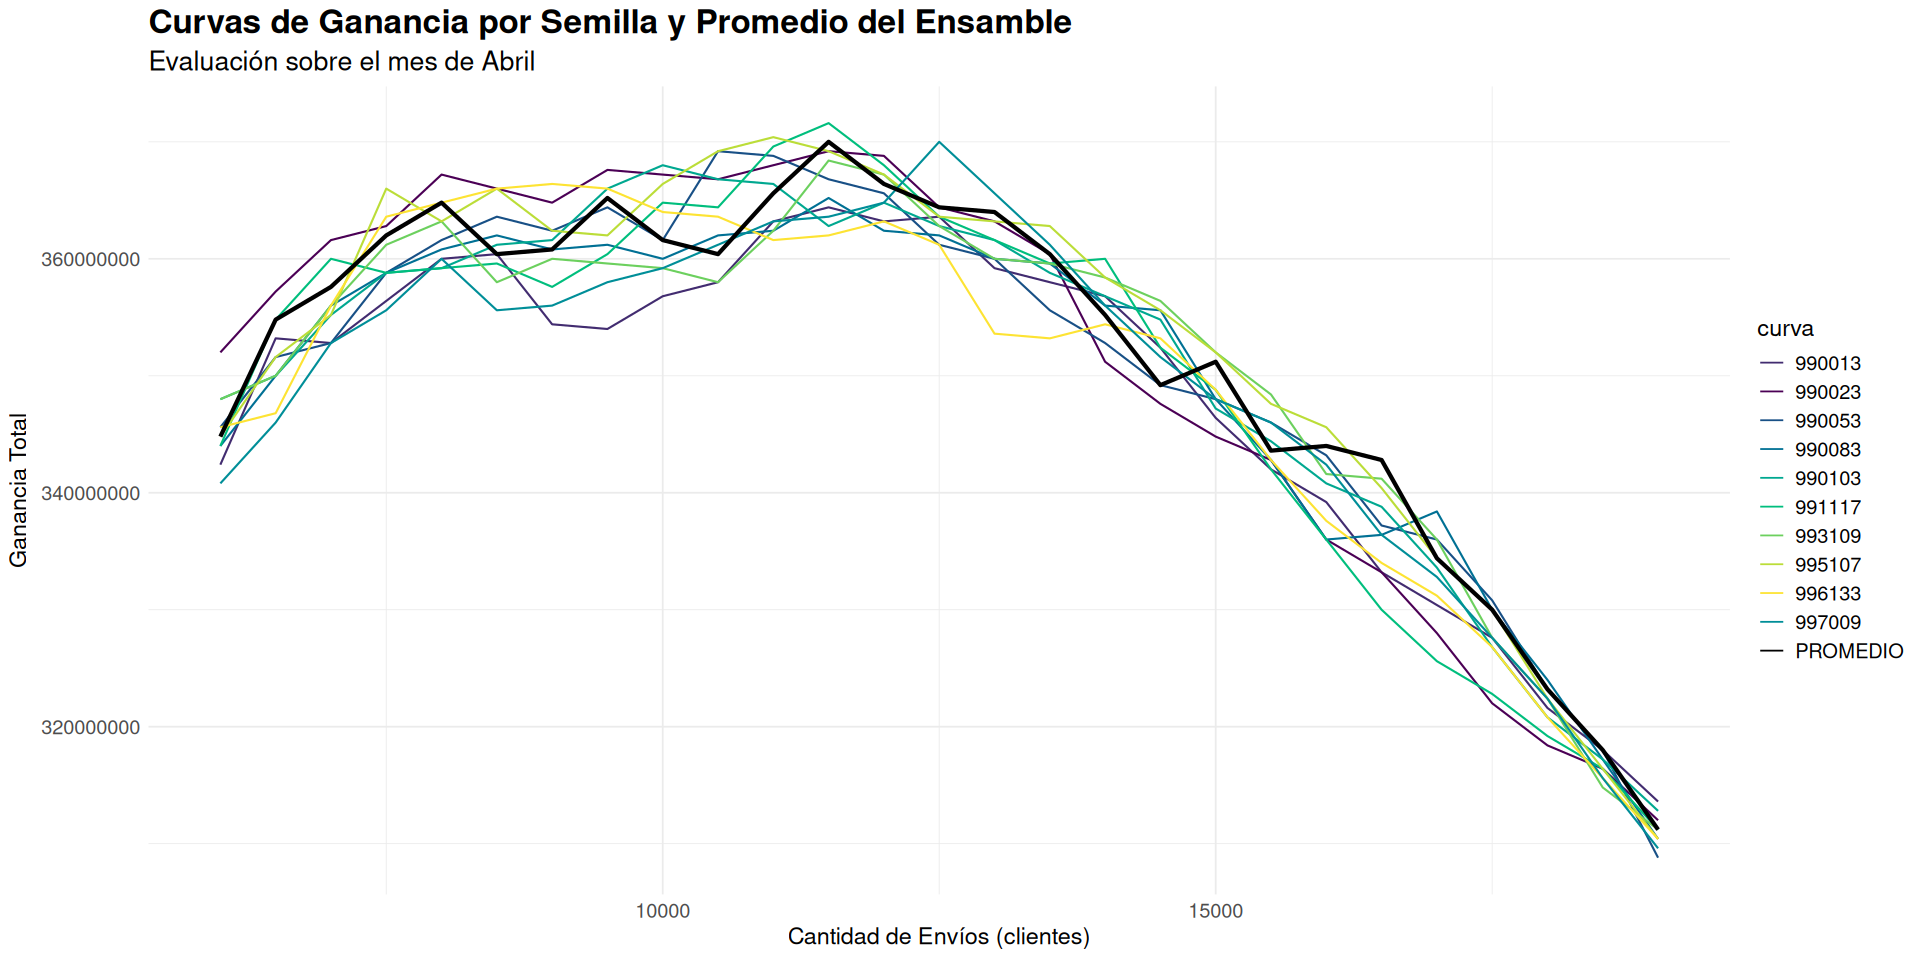

In [ ]:
# Define el tamaño de la imagen de salida en pulgadas (ancho, alto)
options(repr.plot.width = 16, repr.plot.height = 8)


# --- INICIO: SCRIPT PARA GRAFICAR CURVAS DE GANANCIA ---

require("ggplot2")

# 1. Preparamos una tabla para guardar los resultados de todas las curvas
curvas_ganancia <- data.table()

# 2. Obtenemos los nombres de las columnas de predicción
columnas_a_graficar <- c(grep("pred_", colnames(predicciones_ensemble), value = TRUE), "prob_promedio")

# 3. Calculamos la curva de ganancia para cada columna
for (col_pred in columnas_a_graficar) {

  nombre_curva <- sub("pred_", "", col_pred)
  if (col_pred == "prob_promedio") nombre_curva <- "PROMEDIO"

  for (envios in PARAM$cortes) {

    setorderv(predicciones_ensemble, cols = col_pred, order = -1)

    predicciones_ensemble[, Predicted := 0L]
    predicciones_ensemble[1:envios, Predicted := 1L]

    res <- realidad_evaluar(drealidad, predicciones_ensemble)

    curvas_ganancia <- rbind(curvas_ganancia,
                             list(curva = nombre_curva,
                                  envios = envios,
                                  ganancia = res$total))
  }
}

# 4. Creamos el gráfico con todas las curvas
colores <- c("PROMEDIO" = "black", setNames(hcl.colors(length(semillas_ensemble), palette = "viridis"), semillas_ensemble))
tamanos <- c("PROMEDIO" = 1.2, setNames(rep(0.6, length(semillas_ensemble)), semillas_ensemble))

grafico_curvas <- ggplot(curvas_ganancia, aes(x = envios, y = ganancia, color = curva, size = curva)) +
  geom_line() +
  scale_color_manual(values = colores) +
  scale_size_manual(values = tamanos) +
  labs(title = "Curvas de Ganancia por Semilla y Promedio del Ensamble",
       subtitle = "Evaluación sobre el mes de Abril",
       x = "Cantidad de Envíos (clientes)",
       y = "Ganancia Total") +
  guides(size = "none") +
  theme_minimal() +

  # --- NUEVO: Bloque detallado para ajustar el tamaño de todos los textos ---
  theme(
    plot.title = element_text(size = 20, face = "bold"), # Título principal
    plot.subtitle = element_text(size = 16),              # Subtítulo
    axis.title = element_text(size = 14),                 # Títulos de los ejes X e Y
    axis.text = element_text(size = 12),                  # Números en los ejes X e Y
    legend.title = element_text(size = 14),               # Título de la leyenda
    legend.text = element_text(size = 12)                 # Etiquetas dentro de la leyenda
  )



print(grafico_curvas)

ggsave(
  "curvas_de_ganancia.png",   # Nombre del archivo de salida
  plot = grafico_curvas,      # El objeto ggplot que quieres guardar
  width = 16,                 # Ancho de la imagen en pulgadas
  height = 8,                 # Alto de la imagen en pulgadas
  dpi = 300,                  # Resolución (puntos por pulgada) para alta calidad
  bg = "white"                # Fondo blanco para que se vea bien en slides
)

In [ ]:
# --- INICIO: SCRIPT PARA CALCULAR ÓPTIMOS DESDE ARCHIVO EXISTENTE ---

require("data.table")

# --- 1. CONFIGURACIÓN Y FUNCIONES NECESARIAS ---
PARAM <- list()
PARAM$semilla_kaggle <- 314159
PARAM$cortes <- seq(6000, 19000, by = 500)


# --- 2. CARGA Y PREPARACIÓN DE DATOS ---
predicciones_ensemble <- fread("ensemble_predicciones_temp.csv") # <-- CARGA TU ARCHIVO
dataset_original <- fread("~/dmeyf2025/src/ensembles/competencia_01_FE_V2.csv.gz",stringsAsFactors= TRUE)
dfuture <- dataset_original[foto_mes == 202104] # <-- Asegúrate que sea el mes de validación
drealidad <- realidad_inicializar(dfuture, PARAM)
columnas_predicciones_individuales <- grep("pred_", colnames(predicciones_ensemble), value = TRUE)
predicciones_ensemble[, prob_promedio := rowMeans(.SD), .SDcols = columnas_predicciones_individuales]

# --- 3. CÁLCULO DE GANANCIAS ÓPTIMAS ---
optimos_por_estrategia <- data.table()
columnas_a_evaluar <- c(columnas_predicciones_individuales, "prob_promedio")
for (col_pred in columnas_a_evaluar) {
  nombre_curva <- if (col_pred == "prob_promedio") "PROMEDIO" else sub("pred_", "", col_pred)
  ganancia_max_actual <- -Inf
  envios_optimo_actual <- 0
  for (envios in PARAM$cortes) {
    setorderv(predicciones_ensemble, cols = col_pred, order = -1)
    predicciones_ensemble[, Predicted := 0L]
    predicciones_ensemble[1:envios, Predicted := 1L]
    res <- realidad_evaluar(drealidad, predicciones_ensemble)
    if (res$total > ganancia_max_actual) {
      ganancia_max_actual <- res$total
      envios_optimo_actual <- envios
    }
  }
  optimos_por_estrategia <- rbind(optimos_por_estrategia,
                                  list(estrategia = nombre_curva,
                                       envios_optimo = envios_optimo_actual,
                                       ganancia_max = ganancia_max_actual))
}

# --- 4. MOSTRAR RESULTADO FINAL ---
cat("\n\n--- Óptimo de Envíos para cada Estrategia de Predicción ---\n")
print(optimos_por_estrategia)



--- Óptimo de Envíos para cada Estrategia de Predicción ---
    estrategia envios_optimo ganancia_max
        <char>         <num>        <num>
 1:     990023         11500    369200000
 2:     990013         11500    364400000
 3:     990053         10500    369200000
 4:     990083         11500    365200000
 5:     997009         12500    370000000
 6:     990103         10000    368000000
 7:     991117         11500    371600000
 8:     993109         11500    368400000
 9:     995107         11000    370400000
10:     996133          9000    366400000
11:   PROMEDIO         11500    370000000




#### Final Training Junio para Kaggle

In [ ]:
PARAM <- list()
PARAM$experimento <- 5031
PARAM$semilla_primigenia <- 997009
experimento_folder <- paste0("HT", PARAM$experimento)

In [ ]:
# --- INICIO: BLOQUE DE RECUPERACIÓN DE ESTADO ---

# 1. Volvemos a definir los parámetros fijos que se borraron de la memoria
# parametros fijos del LightGBM que se pisaran con la parte variable de la BO
PARAM$lgbm$param_fijos <-  list(
  boosting= "gbdt", # puede ir  dart  , ni pruebe random_forest
  objective= "binary",
  metric= "auc",
  first_metric_only= FALSE,
  boost_from_average= TRUE,
  feature_pre_filter= FALSE,
  force_row_wise= TRUE, # para reducir warnings
  verbosity= -100,

  seed= PARAM$semilla_primigenia,

  max_depth= -1L, # -1 significa no limitar,  por ahora lo dejo fijo
  min_gain_to_split= 0, # min_gain_to_split >= 0
  min_sum_hessian_in_leaf= 0.001, #  min_sum_hessian_in_leaf >= 0.0
  lambda_l1= 0.0, # lambda_l1 >= 0.0
  lambda_l2= 0.0, # lambda_l2 >= 0.0
  max_bin= 31L, # lo debo dejar fijo, no participa de la BO

  bagging_fraction= 1.0, # 0.0 < bagging_fraction <= 1.0
  pos_bagging_fraction= 1.0, # 0.0 < pos_bagging_fraction <= 1.0
  neg_bagging_fraction= 1.0, # 0.0 < neg_bagging_fraction <= 1.0
  is_unbalance= FALSE, #
  scale_pos_weight= 1.0, # scale_pos_weight > 0.0

  drop_rate= 0.1, # 0.0 < neg_bagging_fraction <= 1.0
  max_drop= 50, # <=0 means no limit
  skip_drop= 0.5, # 0.0 <= skip_drop <= 1.0

  extra_trees= FALSE,

  num_iterations= 1200,
  learning_rate= 0.02,
  feature_fraction= 0.5,
  num_leaves= 750,
  min_data_in_leaf= 5000
)


# 2. Leemos el log de la optimización que ya terminó para recuperar los mejores hiperparámetros
#    Asegúrate de que la celda que define el directorio de trabajo (setwd) ya se haya ejecutado
tb_bayesiana <- fread(paste0("../", experimento_folder, "/BO_log.txt"))
setorder(tb_bayesiana, -y) # Ordenamos por el puntaje 'y' (AUC) para encontrar el mejor

# 3. Extraemos y creamos la variable 'mejores_hiperparametros'
#    Asegúrate de que la lista coincida con los hiperparámetros que optimizaste
PARAM$out$lgbm$mejores_hiperparametros <- as.list(tb_bayesiana[1, .(num_leaves, min_data_in_leaf, max_depth,
                                                     feature_fraction, bagging_fraction, learning_rate,
                                                     num_iterations, min_gain_to_split)]) # Ajusta esta lista si es necesario

cat("¡Recuperación Exitosa! Las variables han sido cargadas:\n")
cat("Mejores hiperparámetros:\n")
print(PARAM$out$lgbm$mejores_hiperparametros)

# --- FIN: BLOQUE DE RECUPERACIÓN DE ESTADO ---

¡Recuperación Exitosa! Las variables han sido cargadas:
Mejores hiperparámetros:
$num_leaves
[1] 180

$min_data_in_leaf
[1] 293

$max_depth
[1] 15

$feature_fraction
[1] 0.2176118

$bagging_fraction
[1] 0.742878

$learning_rate
[1] 0.01002797

$num_iterations
[1] 1297

$min_gain_to_split
[1] 1.648119



In [ ]:
# Parámetros para la corrida de PRODUCCIÓN
PARAM$train_final <- c(202101, 202102, 202103, 202104)
PARAM$future      <- c(202106)


In [ ]:
# Reemplaza los siguientes números de ejemplo por TUS 6 "números mágicos"
cortes_optimos <- c( "promedio" = 9000,
                     "990023"   = 9000,
                     "990013"   = 9000,
                     "990053"   = 9500,
                     "990083"   = 9500,
                     "997009"   = 10500 )


In [ ]:
# --- 4. GENERAR PREDICCIONES FINALES (ENSAMBLE DE PRODUCCIÓN) ---
semillas_ensemble <- c(990023, 990013, 990053, 990083, 997009,990103, 991117, 993109, 995107, 996133)
dfuture <- dataset[foto_mes %in% PARAM$future]

In [ ]:
archivo_progreso_prod <- "ensemble_predicciones_final_temp.csv" # Nuevo nombre de archivo de progreso

# Cargamos el progreso si ya existe
if (file.exists(archivo_progreso_prod)) {
  predicciones_ensemble_final <- fread(archivo_progreso_prod)
} else {
  predicciones_ensemble_final <- dfuture[, .(numero_de_cliente, foto_mes)]
}

In [ ]:
campos_buenos <- setdiff(colnames(dataset), c("clase_ternaria", "clase01", "azar", "training"))
dataset_train <- dataset[foto_mes %in% PARAM$train_final]
dataset_train[, clase01 := ifelse(clase_ternaria %in% c("BAJA+1", "BAJA+2"), 1L, 0L)]
dtrain <- lgb.Dataset(data = data.matrix(dataset_train[, campos_buenos, with = FALSE]),
                      label = dataset_train[, clase01])

In [ ]:
PARAM$out$lgbm$mejores_hiperparametros

$num_leaves
[1] 180

$min_data_in_leaf
[1] 293

$max_depth
[1] 15

$feature_fraction
[1] 0.2176118

$bagging_fraction
[1] 0.742878

$learning_rate
[1] 0.01002797

$num_iterations
[1] 1297

$min_gain_to_split
[1] 1.648119

In [ ]:
PARAM$trainingstrategy$trainingstrategy <- 0.25

In [ ]:
PARAM$trainingstrategy$trainingstrategy

[1] 0.25

In [ ]:
for (semilla_actual in semillas_ensemble) {
  nombre_col_pred <- paste0("pred_", semilla_actual)

  if (nombre_col_pred %in% colnames(predicciones_ensemble_final)) {
    cat("Saltando semilla (ya existe en producción):", semilla_actual, "\n")
    next
  }

  cat("\nCorriendo ensamble de PRODUCCIÓN para semilla:", semilla_actual, "\n")
  param_final <- modifyList(PARAM$lgbm$param_fijos, PARAM$out$lgbm$mejores_hiperparametros)
  param_final$seed <- semilla_actual

# Se normaliza el hiperparámetro. Si undersampling es 1.0, no hace nada. Si es otro valor, corrige.
  param_final$min_data_in_leaf <- round(param_final$min_data_in_leaf / PARAM$trainingstrategy$undersampling)

    modelo <- lgb.train(data = dtrain, param = param_final)
  prediccion_actual <- predict(modelo, data.matrix(dfuture[, campos_buenos, with = FALSE]))
  predicciones_ensemble_final[, (nombre_col_pred) := prediccion_actual]

  fwrite(predicciones_ensemble_final, archivo_progreso_prod)
  cat("Progreso de producción guardado para semilla:", semilla_actual, "\n")
}

# ---  Imprimir los parámetros de la última iteración para verificación ---
cat("\nParámetros finales utilizados en la última iteración (semilla:", semilla_actual, "):\n")
print(param_final)

columnas_predicciones <- grep("pred_", colnames(predicciones_ensemble_final), value = TRUE)
predicciones_ensemble_final[, prob_promedio := rowMeans(.SD), .SDcols = columnas_predicciones]
cat("\nPredicción final de ensamble para Junio generada con éxito.\n")



Corriendo ensamble de PRODUCCIÓN para semilla: 990023 
Progreso de producción guardado para semilla: 990023 

Corriendo ensamble de PRODUCCIÓN para semilla: 990013 
Progreso de producción guardado para semilla: 990013 

Corriendo ensamble de PRODUCCIÓN para semilla: 990053 
Progreso de producción guardado para semilla: 990053 

Corriendo ensamble de PRODUCCIÓN para semilla: 990083 
Progreso de producción guardado para semilla: 990083 

Corriendo ensamble de PRODUCCIÓN para semilla: 997009 
Progreso de producción guardado para semilla: 997009 

Corriendo ensamble de PRODUCCIÓN para semilla: 990103 
Progreso de producción guardado para semilla: 990103 

Corriendo ensamble de PRODUCCIÓN para semilla: 991117 
Progreso de producción guardado para semilla: 991117 

Corriendo ensamble de PRODUCCIÓN para semilla: 993109 
Progreso de producción guardado para semilla: 993109 

Corriendo ensamble de PRODUCCIÓN para semilla: 995107 
Progreso de producción guardado para semilla: 995107 

Corriendo

In [ ]:
# --- 5. PASO FINAL: GENERAR ENVÍOS CON CORTES FINOS PARA EL ENSAMBLE ---
dir.create("kaggle", showWarnings = FALSE)
PARAM$cortes <- seq(8500, 12500, by = 200)
cat("Se generarán", length(PARAM$cortes), "archivos de envío para el ensamble promedio...\n")

for (envios_actual in PARAM$cortes) {
    setorder(predicciones_ensemble_final, -prob_promedio)
    predicciones_ensemble_final[, Predicted := 0L]
    predicciones_ensemble_final[1:envios_actual, Predicted := 1L]
    archivo_salida <- paste0("kaggle/KA", PARAM$experimento, "_FINAL_promedio_", envios_actual, ".csv")
    fwrite(predicciones_ensemble_final[, .(numero_de_cliente, Predicted)],
           file = archivo_salida,
           sep = ",")
    cat("Archivo generado para corte", envios_actual, ":", archivo_salida, "\n")
}

cat("\n\n¡Proceso finalizado! Revisa tu carpeta 'kaggle' para encontrar los envíos de corte fino.\n")


Se generarán 21 archivos de envío para el ensamble promedio...
Archivo generado para corte 8500 : kaggle/KA5031_FINAL_promedio_8500.csv 
Archivo generado para corte 8700 : kaggle/KA5031_FINAL_promedio_8700.csv 
Archivo generado para corte 8900 : kaggle/KA5031_FINAL_promedio_8900.csv 
Archivo generado para corte 9100 : kaggle/KA5031_FINAL_promedio_9100.csv 
Archivo generado para corte 9300 : kaggle/KA5031_FINAL_promedio_9300.csv 
Archivo generado para corte 9500 : kaggle/KA5031_FINAL_promedio_9500.csv 
Archivo generado para corte 9700 : kaggle/KA5031_FINAL_promedio_9700.csv 
Archivo generado para corte 9900 : kaggle/KA5031_FINAL_promedio_9900.csv 
Archivo generado para corte 10100 : kaggle/KA5031_FINAL_promedio_10100.csv 
Archivo generado para corte 10300 : kaggle/KA5031_FINAL_promedio_10300.csv 
Archivo generado para corte 10500 : kaggle/KA5031_FINAL_promedio_10500.csv 
Archivo generado para corte 10700 : kaggle/KA5031_FINAL_promedio_10700.csv 
Archivo generado para corte 10900 : kaggl

In [ ]:
stop("Ejecución detenida aquí a propósito.")

ERROR: Error: Ejecución detenida aquí a propósito.


FINAL TRAINING OLD